In [0]:
!pip install torch
!pip install torchtext
!pip install -U spacy
!python -m spacy download en
!pip install nltk

    100% |████████████████████████████████| 591.8MB 26kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x620be000 @  0x7ff203a3e2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 71kB 3.3MB/s 
Requirement already up-to-date: spacy in /usr/local/lib/python3.6/dist-packages (2.0.18)
    100% |████████████████████████████████| 13.9MB 3.0MB/s 
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
cufflinks 0.14.6 has requirement plotly>=3.0.0, but you'll have plotly 1.12.12 which is incompatible.
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6

    Linking successful
    /usr/local/lib/python3.6/dist-packages/

In [0]:
import torch
from torchtext import data
from torchtext import datasets
import random
import nltk
import re
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
SEED = 10
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True #for reproducible results

In [0]:
def clean_text(text):
    text = text.lower()
    text = re.compile('<.*?>').sub(" ", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"[-()\"#/@;:<>{}+=~|.?,]", "", text)
    text = text.split()
    return text

TEXT = data.Field(tokenize=clean_text,lower=True, fix_length=800)
LABEL = data.LabelField(dtype = torch.float)

In [0]:
from torchtext import datasets
train_data, test_data = datasets.IMDB.splits(text_field=TEXT,label_field=LABEL,)
train_data, valid_data = train_data.split(split_ratio= 0.8, random_state=random.seed(SEED))

In [0]:
print('Number of training examples: {}'.format(len(train_data)))
print('Number of validation examples: {}'.format(len(valid_data)))
print(vars(train_data[0]))

Number of training examples: 20000
Number of validation examples: 5000
{'text': ['wow', 'this', 'movie', 'bored', 'the', 'pants', 'off', 'me', 'when', 'i', 'saw', 'it', 'bland', 'pointless', 'and', 'unmoving', 'apparently', 'ash', 'and', 'co', 'can', 'travel', 'through', 'time', 'with', 'the', 'help', 'of', 'the', 'spirit', 'of', 'the', 'forest', "'princess", "mononoke'", 'much', 'there', 'they', 'meet', 'a', 'dorky', 'kid', 'named', 'sam', 'and', 'the', 'plot', 'begins', 'so', 'tom', 'ash', 'and', 'huck', 'sam', 'get', 'high', 'with', 'nature', 'become', 'hippies', 'and', 'try', 'to', 'free', 'celebi', 'the', 'spirit', 'from', 'some', 'weirdo', 'hunter', 'guy', 'i', "don't", 'even', 'know', 'what', 'else', 'went', 'on', 'it', 'all', 'went', 'by', 'in', 'a', 'blur', "ash's", 'friends', 'were', 'hardly', 'in', 'it', 'and', 'all', 'the', 'fight', 'scenes', 'were', 'boring', 'after', 'saving', 'the', 'day', 'ash', 'and', 'his', 'infamous', 'friends', 'must', 'return', 'to', 'their', 'time

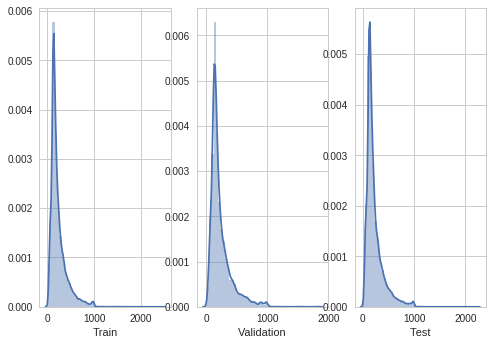

In [0]:
train_data_dist = [len(train_data[i].text) for i in range(len(train_data))]
valid_data_dist = [len(valid_data[i].text) for i in range(len(valid_data))]
test_data_dist = [len(test_data[i].text) for i in range(len(test_data))]

sns.set(style='whitegrid')
f, axes = plt.subplots(1, 3)

sns.distplot(a = train_data_dist,ax=axes[0], axlabel='Train')
sns.distplot(a = valid_data_dist,ax=axes[1], axlabel='Validation')
sns.distplot(a = test_data_dist,ax=axes[2], axlabel='Test')


In [0]:
TEXT.build_vocab(train_data, max_size=25000, vectors="glove.6B.100d")
LABEL.build_vocab(train_data)

In [0]:
import torch.nn as nn
import torch.nn.functional as F

In [0]:

class CNN(nn.Module):
    def __init__(self,vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.requires_grad = False
        self.conv_0 = nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(filter_sizes[0],embedding_dim))
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(filter_sizes[1],embedding_dim))
        self.conv_2 = nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(filter_sizes[2],embedding_dim))
        self.fc = nn.Linear(len(filter_sizes)*n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        #x = [sen_len, batch_size]
        x = x.permute(1,0)
        #x = [batch_size, sen_length]
        embedded = self.embedding(x)
        
        # embedded - [batch_size, sent_len, emb_dim]
        embedded = embedded.unsqueeze(1)
        #embedded = [batch size, 1, sent len, emb dim]
       
        conved_0 = F.relu(self.conv_0(embedded).squeeze(3))
        conved_1 = F.relu(self.conv_1(embedded).squeeze(3))
        conved_2 = F.relu(self.conv_2(embedded).squeeze(3))
        
        #conv_n = [batch size, n_filters, sent len - filter_sizes[n]]
        
        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim=1))

        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

In [0]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [3,4,5]
OUTPUT_DIM = 1
DROPOUT = 0.5
BATCH_SIZE = 128

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT)

In [0]:
pretrained_embeddings  = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.3581, -0.3348, -0.4465,  ..., -0.7128, -0.1006, -0.2799],
        [ 0.3896,  0.0446, -0.3506,  ...,  0.1727,  0.0145, -0.9884],
        [ 0.0994, -0.7076, -0.0949,  ..., -0.0898, -1.1580, -0.1628]])

In [0]:
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

optimizer = optim.Adam(model.parameters(),lr=0.01)
criterion = nn.BCEWithLogitsLoss()
model = model.to(device)
criterion = criterion.to(device)


train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits((train_data,valid_data,test_data), batch_size=BATCH_SIZE,device=device)

In [0]:
def binary_accuracy(preds,y):
    
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds==y).float()
    acc = correct.sum()/len(correct)
    return acc


def precision_recall_f1(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    tp = y*rounded_preds
    fp = (y==0).float()*rounded_preds
    tn = (y==0).float()*(rounded_preds==0).float()
    fn = y*(rounded_preds==0).float()
    
    return sum(tp), sum(fp), sum(tn), sum(fn)
    
  
  
  
  
def train(model, iterator, optimizer, criterion):
        
    epoch_loss= 0
    epoch_acc = 0
    tp = 0
    fp = 0
    tn = 0
    fn = 0
        
    model.train()
        
    for batch in iterator:          
        optimizer.zero_grad()
            
        predictions = model(batch.text).squeeze(1)
        loss = criterion(predictions, batch.label)
        acc = binary_accuracy(predictions, batch.label)
        a, b, c, d = precision_recall_f1(predictions, batch.label)
       
        loss.backward() 
        optimizer.step()
            
        epoch_loss += loss.item()
        epoch_acc +=acc.item()
        tp += a.item()
        fp += b.item()
        tn += c.item()
        fn += d.item()
            
    return epoch_loss/len(iterator), epoch_acc/len(iterator), tp, fp, tn, fn
      
      

def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:
            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)
            a, b, c, d = precision_recall_f1(predictions, batch.label)
            
            tp += a.item()
            fp += b.item()
            tn += c.item()
            fn += d.item()
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), tp, fp, tn, fn

In [0]:
N_EPOCHS = 3

for epoch in tqdm(range(N_EPOCHS)):
    model.embedding.weight.requires_grad=True
    if epoch>0:
        lr = 0.001
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        model.embedding.weight.requires_grad=False
    train_loss, train_acc, train_tp, train_fp, train_tn, train_fn = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc, valid_tp, valid_fp, valid_tn, valid_fn = evaluate(model, valid_iterator, criterion)
    valid_precision = valid_tp/(valid_tp+valid_fp)
    valid_recall = valid_tp/(valid_tp+valid_fn)
    valid_f1= (2*valid_precision*valid_recall)/(valid_precision+valid_recall)
    print('| Epoch: {} | Train Loss: {} | Train Acc: {} | Val. Loss: {} | Val. Acc: {} | Val. F1 {} |'.format(epoch+1,train_loss, train_acc*100,valid_loss, valid_acc*100, valid_f1))


 33%|███▎      | 1/3 [00:46<01:33, 46.54s/it]

| Epoch: 1 | Train Loss: 0.4410485627165266 | Train Acc: 79.61285828025477 | Val. Loss: 0.28408743254840374 | Val. Acc: 88.1640625 | Val. F1 0.877079107505071 |



 67%|██████▋   | 2/3 [01:05<00:38, 38.19s/it]

| Epoch: 2 | Train Loss: 0.1850227826530007 | Train Acc: 93.33200636942675 | Val. Loss: 0.2833555852994323 | Val. Acc: 88.359375 | Val. F1 0.8807523009203682 |



100%|██████████| 3/3 [01:23<00:00, 32.35s/it]


| Epoch: 3 | Train Loss: 0.16678182337029723 | Train Acc: 93.79478503184714 | Val. Loss: 0.2861498072743416 | Val. Acc: 88.4765625 | Val. F1 0.8824232762056596 |


In [0]:
test_loss, test_acc, test_tp, test_fp, test_tn, test_fn= evaluate(model, test_iterator, criterion)
test_precision = test_tp/(test_tp+test_fp)
test_recall = test_tp/(test_tp+test_fn)
test_f1 = (2*test_precision*test_recall)/(test_precision+test_recall)

print('| Test Loss: {} | Test Acc: {} | Test F1: {} |'.format(test_loss, test_acc*100, test_f1))